In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable
from functools import reduce
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import trange
import sys
import gc
from model.resnet50model import ResNet50
from utils import mem_start, mem_end

In [2]:
# Отключаем средства дебаггинга
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [26]:
PATH = 'C:/Users/Artem/Desktop/Data_Science/My_programms/BoostResNet DL course project/src/baseline/data'
BATCH_SIZE = 512
LR = 0.1
WEIGHT_DECAY = 5e-4
EPOCHS = 50
USE_AMP = True

In [4]:
# Определим устройство
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == 'cuda':
    torch.backends.cudnn.benchmark = True # используем так как есть свертки
print("Using {} device".format(device))

Using cuda device


## Загрузим датасеты

Определим конвейер преобразования изображений

In [5]:
transform_train = transforms.Compose([
                            transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

Загрузим датасет CIFAR-10

In [6]:
# train cifar-10
dataset_cifar = torchvision.datasets.CIFAR10(root=PATH, 
                                             train=True, 
                                             download=True, 
                                             transform=transform_train)

Files already downloaded and verified


In [7]:
# test cifar-10
cifar_test = torchvision.datasets.CIFAR10(root=PATH, 
                                          train=False, 
                                          download=True, 
                                          transform=transform_test)

Files already downloaded and verified


Загрузим датасет SVHN

In [6]:
# train
dataset_svhn = torchvision.datasets.SVHN(root=f'{PATH}/svhn', 
                                         split='train', 
                                         download=True, 
                                         transform=transform_test)

Using downloaded and verified file: C:/Users/Artem/Desktop/Data_Science/My_programms/BoostResNet DL course project/src/baseline/data/svhn\train_32x32.mat


In [7]:
# test
svhn_test = torchvision.datasets.SVHN(root=f'{PATH}/svhn', 
                                      split='test', 
                                      download=True, 
                                      transform=transform_test)

Using downloaded and verified file: C:/Users/Artem/Desktop/Data_Science/My_programms/BoostResNet DL course project/src/baseline/data/svhn\test_32x32.mat


In [8]:
# разделим датасет svhn
val_size = 12000
train_size = len(dataset_svhn)  - val_size

In [9]:
train_svhn, val_svhn = random_split(dataset_svhn, [train_size, val_size])

## Подготовим загрузчики

In [8]:
# CIFAR-10
train_loader_cifar = DataLoader(dataset_cifar, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True, 
                                num_workers=2,
                                pin_memory=True)

val_loader_cifar = DataLoader(cifar_test, 
                              batch_size=BATCH_SIZE,
                              shuffle=False, 
                              num_workers=2,
                              pin_memory=True)

In [10]:
# SVHN
train_loader_svhn = DataLoader(train_svhn, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               num_workers=2,
                               pin_memory=True)

val_loader_svhn = DataLoader(val_svhn, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2,
                             pin_memory=True)

In [10]:
for X, y in train_loader_cifar:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([512, 3, 32, 32])
Shape of y:  torch.Size([512]) torch.int64


## Baseline: ResNet50

In [41]:
model = ResNet50()
# В случае дообучения
#model.load_state_dict(torch.load('model_name'))
model = model.to(device)

In [42]:
loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.AdamW(model.parameters()) # Используем для дообучения
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)

In [43]:
# Training logs
interval = 100
train_ts, train_loss, train_acc = [], [], []
val_ts, val_loss, val_acc = [], [], []

In [44]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(train_ts, train_acc, c='darkblue', lw=3)
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [45]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    correct, size = 0, 0
    train_error = 0
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update() 
        train_error += loss.item()
        # Посчитаем accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        size += len(X)
        # Сбросим градиенты альтернативным способом
        for param in model.parameters():
            param.grad = None
        # Progress output
    train_ts.append(epoch+1)
    train_loss.append(train_error / num_batches)
    train_acc.append(correct / size)
    show_progress(epoch+1)

In [46]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

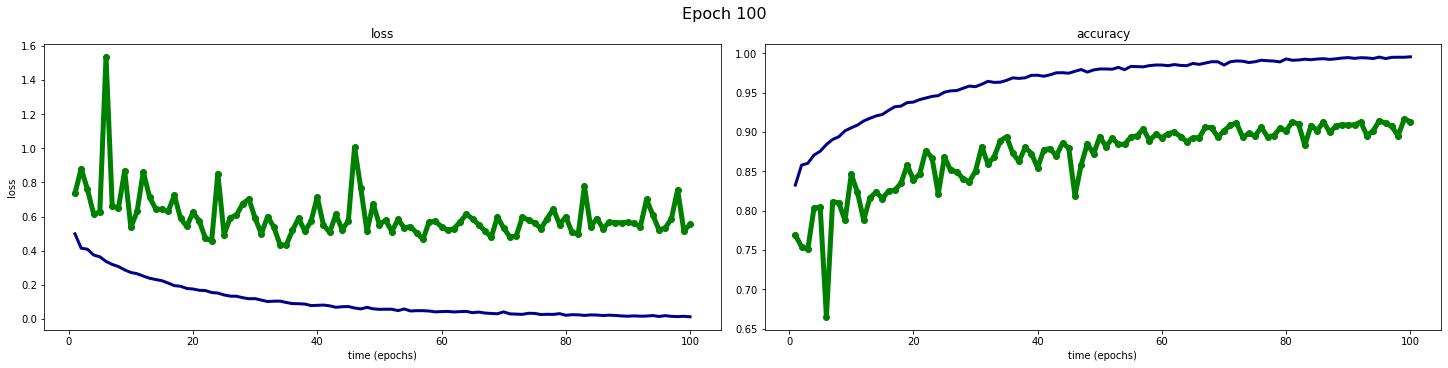

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [37:32<00:00, 45.04s/it]

6974021632


In [48]:
mem_start()
for t in trange(EPOCHS):
    train(t+50, train_loader_cifar, model, loss_fn, optimizer)
    test(t+50, val_loader_cifar, model, loss_fn)
    scheduler.step()
mem_end()

In [49]:
print(max(val_acc), max(train_acc))

0.9165 0.99562
